In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import akantu as aka
import numpy as np
import matplotlib.pyplot as plt

from contact_mechanics_internodes import ContactMechanicsInternodes
from helper import plot_mesh, write_solution

In [12]:
mesh_file = 'mesh/contact2d_circle.msh'
material_file = 'material/material.dat'
spatial_dimension = 2
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.05, aka._y), 'secondary_fixed')

# Get positions of all nodes, surface connectivity and candidate nodes
nodal_positions = mesh.getNodes()
surface_connectivity = mesh.getConnectivity(aka._segment_2)
nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()
external_force = model.getExternalForce()
nodal_displacements = model.getDisplacement()
nodes_blocked = model.getBlockedDOFs()

model.assembleMass()
M = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('M')).toarray()

model.assembleStiffnessMatrix()
K = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('K')).toarray()

E = model.getMaterial(0).getReal("E")

# Set initial conditions
internodes_model = ContactMechanicsInternodes(spatial_dimension, nodal_positions, nodal_displacements, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary, nodes_blocked, external_force, M, K, E)

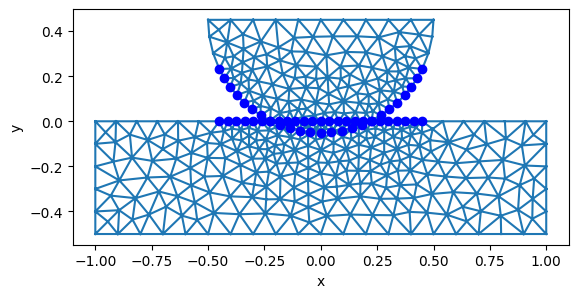

----> Starting iteration 1 <----


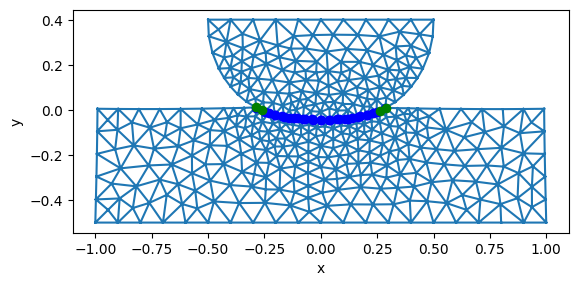

----> Starting iteration 2 <----


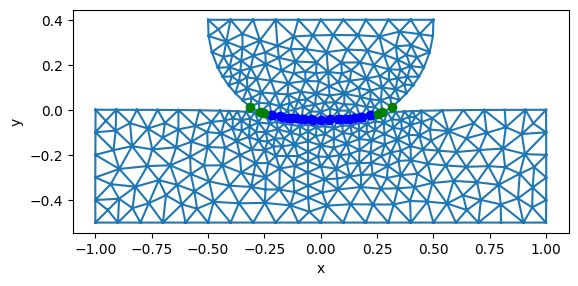

----> Starting iteration 3 <----


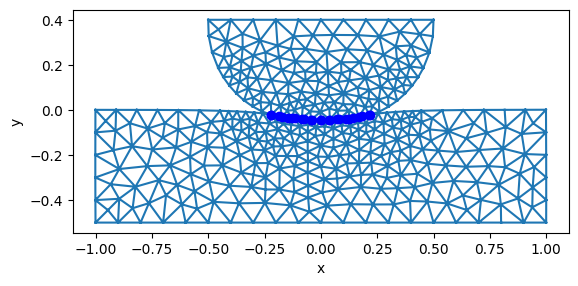


successfully converged in 3 iterations


In [13]:
# Plot initial configuration
plot_mesh(internodes_model.nodal_positions, mesh.getConnectivity(aka._triangle_3),
    np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary))

max_iter = 10
for i in range(max_iter):
    print("----> Starting iteration", i+1, "<----")

    # Find the interface nodes
    internodes_model.define_interface()

    # Assemble model
    internodes_model.assemble_full_model()

    # Solve model
    displacements, lambdas = internodes_model.solve_direct()

    # Update the interface nodes and check if it converged
    converged, nodes_added_primary, nodes_added_secondary, nodes_dumped_primary, nodes_dumped_secondary = internodes_model.update_interface(displacements, lambdas, return_changes=True)

    # Plot the obtained solution
    plot_mesh(internodes_model.nodal_positions + displacements,
        mesh.getConnectivity(aka._triangle_3),
        np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary),
        np.union1d(nodes_added_primary, nodes_added_secondary),
        np.union1d(nodes_dumped_primary, nodes_dumped_secondary))

    if converged:
        print('\nsuccessfully converged in', i+1, 'iterations')
        break

In [14]:
nodal_positions_new = internodes_model.nodal_positions + displacements
write_solution("mesh/contact2d_circle.msh", nodal_positions_new)